# Dataset Description

Download the dataset using following API command - `kaggle competitions download -c mercari-price-suggestion-challenge`



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
MERCARI_PATH_TRAIN = os.path.join(os.getcwd(), "dataset/mercari-price-suggestion-challenge/train.tsv")
MERCARI_PATH_TEST = os.path.join(os.getcwd(), "dataset/mercari-price-suggestion-challenge/test.tsv")

In [3]:
data1 = pd.read_csv(MERCARI_PATH_TRAIN, delimiter='\t')
data2 = pd.read_csv(MERCARI_PATH_TEST, delimiter='\t')

data = pd.concat([data1, data2])
data = data.drop(["train_id", "test_id"], axis=1)
data = data.reset_index(drop=True)
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
data.shape

(2175894, 7)

In [5]:
data.isna().sum()

name                      0
item_condition_id         0
category_name          9385
brand_name           928207
price                693359
shipping                  0
item_description          6
dtype: int64

NA values for brand name could be for unbranded goods

We may also need to train a model where there is no category or item_description provided

In [6]:
data.duplicated().sum()

85

In [7]:
data.name.value_counts()

name
Bundle                                   3343
Reserved                                  696
Converse                                  656
Dress                                     606
BUNDLE                                    599
                                         ... 
Short jumpsuit                              1
purple nikes                                1
Malibu heat                                 1
NEW ** TC LULAROE ** LEOPARD/CHEETAH        1
FREESHIP 2 Floral Scrub Tops, medium.       1
Name: count, Length: 1750617, dtype: int64

This column is not categorical and potentially at test time a new name of the product may be given

In [8]:
data.item_condition_id.value_counts()

item_condition_id
1    940630
3    633834
2    551032
4     46815
5      3583
Name: count, dtype: int64

condition_id is categorical with only 5 values

In [9]:
data.category_name.value_counts()

category_name
Women/Athletic Apparel/Pants, Tights, Leggings    88077
Women/Tops & Blouses/T-Shirts                     68082
Beauty/Makeup/Face                                50352
Beauty/Makeup/Lips                                44028
Electronics/Video Games & Consoles/Games          39178
                                                  ...  
Handmade/Toys/Doll Clothes                            1
Handmade/Holidays/Patriotic                           1
Handmade/Accessories/Cuff                             1
Other/Pet Supplies/Pet Food                           1
Handmade/Toys/Baby                                    1
Name: count, Length: 1310, dtype: int64

Seems like we have to extract multiple categories from the categorical column and build a huge sparse matrix (consisting only of categories)

In [10]:
"""
num_cats = set()
for i in range(data.shape[0]):
    if not data.loc[i, 'category_name'].is_na():
        num_cats.add(len(data.loc[i, 'category_name'].split("/")))
print("Distinct number of categories :", num_cats)

del num_cats
num_cats = {1:0, 2:0, 3:0, 4:0, 5:0}
for i in range(data.shape[0]):
    num_cats[len(data.loc[i, 'category_name'].split("/"))] += 1
print("number of records with given num of categories", num_cats)
"""

'\nnum_cats = set()\nfor i in range(data.shape[0]):\n    if not data.loc[i, \'category_name\'].is_na():\n        num_cats.add(len(data.loc[i, \'category_name\'].split("/")))\nprint("Distinct number of categories :", num_cats)\n\ndel num_cats\nnum_cats = {1:0, 2:0, 3:0, 4:0, 5:0}\nfor i in range(data.shape[0]):\n    num_cats[len(data.loc[i, \'category_name\'].split("/"))] += 1\nprint("number of records with given num of categories", num_cats)\n'

There are only upto 5 categories per record and majority records have only 3 categories so we'll transform the records to only have first 3 categories (and discard others or keep them empty)

In [11]:
data.brand_name.value_counts()

brand_name
Nike                 79277
PINK                 79092
Victoria's Secret    70508
LuLaRoe              45598
Apple                25435
                     ...  
!iT Jeans                1
Ware                     1
Edelbrock                1
Piazza Sempione          1
PediaCare                1
Name: count, Length: 5289, dtype: int64

Only few brand names but the column doesn't seem to be categorical

In [12]:
data.shipping.value_counts()

shipping
0    1202364
1     973530
Name: count, dtype: int64

Shipping is categorical, whereas price is clearly a float and item description is a string

### Findings :
1. item_condition_id, shipping and potentially category_name column could be considered categorical
2. all the other columns are plain-text, and can be useful features in predicting price of an item (for eg: apple device might be more expensive than a similar samsung device etc.)

# EDA

## 1. Price Distribution

Most of the models work well when target value is normally distributed, so we'll look for common feature transforms that transforms the skewed distribution to normal distribution


### 1. No transform

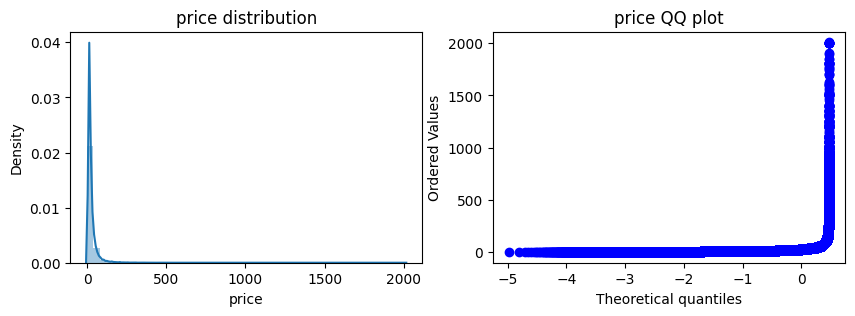

In [13]:
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.distplot(data['price'])
plt.title('price distribution')
plt.subplot(1, 2, 2)
stats.probplot(data['price'], dist="norm", plot=plt)
plt.title('price QQ plot')
plt.show()

### 2. log-transform

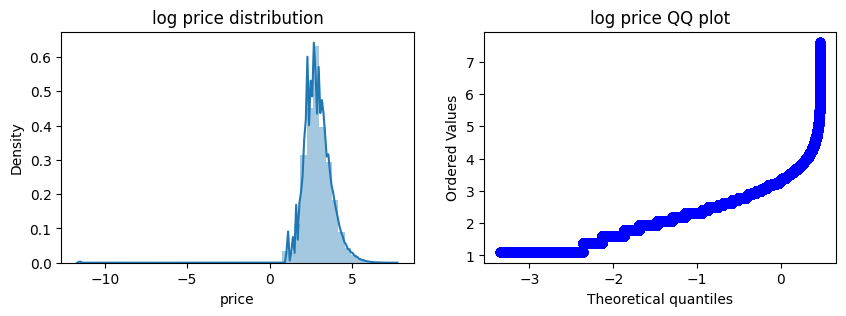

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.distplot(np.log(data['price']+0.00001))
plt.title('log price distribution')
plt.subplot(1, 2, 2)
stats.probplot(np.log(data['price']), dist="norm", plot=plt)
plt.title('log price QQ plot')
plt.show()

We'll take the log-transformed price for now as it looks lot less skewed

In [15]:
data['tprice'] = np.log(data['price']+0.00001)

## 2. Distribution of other categorical attributes wrt price

<Axes: xlabel='item_condition_id', ylabel='tprice'>

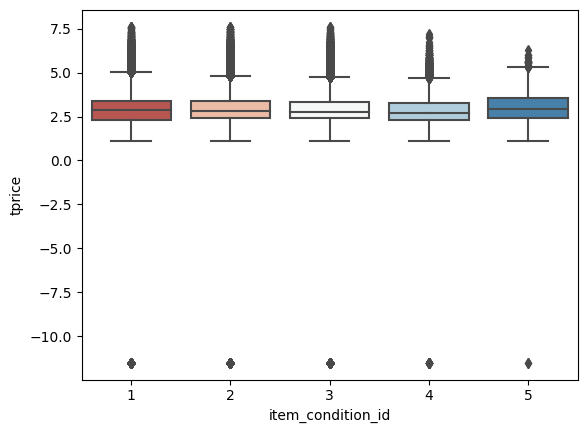

In [16]:
# distribution of tprice against different item conditions
sns.boxplot(x = 'item_condition_id', y = data['tprice'], data = data, palette = sns.color_palette('RdBu',5))

Price distribution is similar across item conditions

<Axes: xlabel='shipping', ylabel='tprice'>

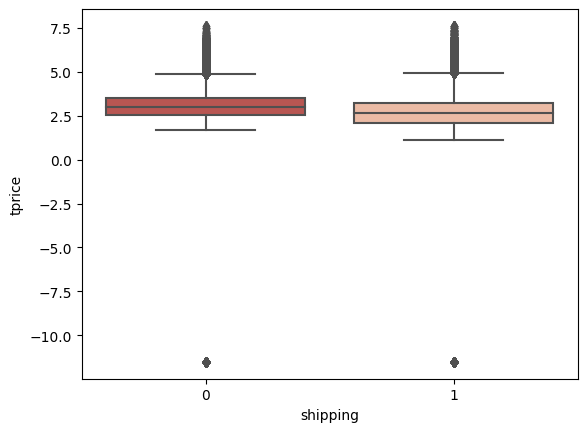

In [17]:
# distribution of tprice against shipping = 0 or 1
sns.boxplot(x = 'shipping', y = data['tprice'], data = data, palette = sns.color_palette('RdBu',5))

Distribution is nearly the same except when shipping = 0, price is slightly higher

# Data Pre-processing

In [18]:
# change the category_name column to have only upto 3 categories, and drop the old category column
data["category_name"].fillna(value='missing', inplace=True)
data[["cat1", "cat2", "cat3"]] = data["category_name"].str.split('/', expand=True)[[0, 1, 2]]

data["item_description"] = data["item_description"].replace({"No description yet":np.nan})
data['brand_name'].fillna(value='un-branded', inplace=True)
data['item_description'].fillna(value='missing', inplace=True)

data = data.drop("category_name", axis=1)

In [19]:
data["cat1"].fillna(value='missing', inplace=True)
data["cat2"].fillna(value='missing', inplace=True)
data["cat3"].fillna(value='missing', inplace=True)

In [20]:
for brand, v in data['brand_name'].value_counts().items():
    if v < 1000:
        data.loc[data['brand_name'] == brand, 'brand_name'] = 'others'

In [21]:
# One-hot encode each sparse category column
from sklearn.preprocessing import LabelBinarizer
cat_features = ["cat1", "cat2", "cat3", "brand_name"]
binarized_cols = []

for column in cat_features:
    binarizer = LabelBinarizer(sparse_output=True)
    binarized_col = binarizer.fit_transform(data[column])
    binarized_cols.append(binarized_col)

In [22]:
cat_features = ["item_condition_id", "shipping"]

for column in cat_features:
    binarizer = LabelBinarizer(sparse_output=False)
    binarized_col = binarizer.fit_transform(data[column])
    binarized_cols.append(binarized_col)

In [23]:
data = data.drop(["brand_name", "cat1", "cat2", "cat3", "item_condition_id", "shipping"], axis=1)

Computing TF-IDF for textual features : name and item_description

In [24]:
data['item_description'] = data['item_description'].astype('<U28')
data['name'] = data['name'].astype('<U28')

In [25]:
# Handle all the text data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer

data['name'] = data['name'].str.replace('\[rm\]', '')
data['item_description'] = data['item_description'].str.replace('\[rm\]', '')

data['name'] = data['name'].apply(lambda x: np.char.lower(x))
data['item_description'] = data['item_description'].apply(lambda x: np.char.lower(x))

data['name'] = data['name'].str.replace("'", "")
data['item_description'] =  data['item_description'].str.replace("'", "")

stemmer = PorterStemmer()
data['name'] = data['name'].apply(lambda x: stemmer.stem(x))
data['item_description'] = data['item_description'].apply(lambda x: stemmer.stem(x))

symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
for s in symbols:
    data['name'] = data['name'].str.replace(s, ' ')
    data['item_description'] = data['item_description'].str.replace(s, ' ')

In [26]:
# Create TF-IDF vectorizer
vectorized_cols = []
tfidf_vectorizer = TfidfVectorizer(min_df=7, max_features=10000)
vectorized_col = tfidf_vectorizer.fit_transform(data["name"])
vectorized_cols.append(vectorized_col)

tfidf_vectorizer = TfidfVectorizer(min_df=15, ngram_range=(1, 2), max_features=40000)
vectorized_col = tfidf_vectorizer.fit_transform(data["item_description"])
vectorized_cols.append(vectorized_col)

data = data.drop(["name", "item_description"], axis=1)

In [27]:
data.head()

,price,tprice
0,10.0,2.302586
1,52.0,3.951244
2,10.0,2.302586
3,35.0,3.555348
4,44.0,3.784190


In [28]:
from scipy.sparse import hstack

X = hstack([binarized_cols[0], binarized_cols[1], binarized_cols[2],
            binarized_cols[3], binarized_cols[4], binarized_cols[5], 
            vectorized_cols[0], vectorized_cols[1]]).tocsr()

y = data["tprice"]

In [29]:
# save memory
del data, binarized_cols, vectorized_cols

# Model Training

1. SGDRegressor
2. Random Forest Regressor
3. Gradient Boosted Trees (LightGBM)

In [30]:
# Too many target values are nan, so we replace the nan values with median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
y_si = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_si, test_size=0.20, random_state=42)

In [32]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

def fitreg_randomized_search(reg,
                             X_train,
                             y_train,
                             params,
                             cv=5,
                             n_iter=10,
                             scoring='neg_mean_squared_error',
                            verbose=1,
                            n_jobs=8):
    search = RandomizedSearchCV(estimator=reg,
                               param_distributions=params,
                               scoring=scoring,
                               cv=cv,
                               verbose=verbose,
                               random_state=42,
                               n_iter=n_iter,
                               n_jobs=n_jobs)
    search.fit(X_train, y_train)
    return search.best_estimator_

def fitreg_grid_search(reg,
                       X_train,
                       y_train,
                       params,
                       cv=5,
                       n_iter=10,
                       scoring='neg_mean_squared_error',
                       verbose=1,
                       n_jobs=8):
    search = GridSearchCV(estimator=reg,
                       param_grid=params,
                       scoring=scoring,
                       cv=cv,
                       verbose=verbose,
                       n_iter=n_iter,
                       n_jobs=n_jobs)
    search.fit(X_train, y_train)
    return search.best_estimator_


def compute_performance(reg, X_test, y_test):
    def map_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    y_pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mape = map_error(y_test, y_pred)
    
    return rmse, r2, mape, evs

## 1. SGDRegressor

In [34]:
from sklearn.linear_model import SGDRegressor

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.15, 0.3, 0.5],
    'max_iter': [1000, 2000, 3000],
    'learning_rate': ['constant', 'adaptive']
}

sgd_reg = SGDRegressor()
sgd_reg = fitreg_randomized_search(sgd_reg, X_train, y_train, param_grid, verbose=2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=0.01, l1_ratio=0.5, learning_rate=adaptive, max_iter=2000, penalty=elasticnet; total time=  21.6s
[CV] END alpha=0.01, l1_ratio=0.5, learning_rate=adaptive, max_iter=2000, penalty=elasticnet; total time=  21.1s
[CV] END alpha=0.01, l1_ratio=0.5, learning_rate=adaptive, max_iter=2000, penalty=elasticnet; total time=  20.7s
[CV] END alpha=0.01, l1_ratio=0.5, learning_rate=adaptive, max_iter=2000, penalty=elasticnet; total time=  20.7s
[CV] END alpha=0.01, l1_ratio=0.5, learning_rate=adaptive, max_iter=2000, penalty=elasticnet; total time=  20.7s
[CV] END alpha=0.01, l1_ratio=0.15, learning_rate=constant, max_iter=1000, penalty=l2; total time=   3.1s
[CV] END alpha=0.01, l1_ratio=0.15, learning_rate=constant, max_iter=1000, penalty=l2; total time=   3.1s
[CV] END alpha=0.01, l1_ratio=0.15, learning_rate=constant, max_iter=1000, penalty=l2; total time=   3.1s
[CV] END alpha=0.01, l1_ratio=0.15, learning_rate=consta

In [35]:
# Performance metrics
rmse, r2, mape, evs = compute_performance(sgd_reg, X_test, y_test)
print(f"RMSE : {rmse:.3f}")
print(f"R2   : {r2:.3f}")
print(f"MAPE : {mape:.3f}")
print(f"EVS  : {evs:.3f}")

RMSE : 0.596
R2   : 0.292
MAPE : 14.804
EVS  : 0.292


## 2. Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_reg = RandomForestRegressor(n_jobs=10)
rf_reg = fitreg_randomized_search(rf_reg, X_train, y_train, param_grid, verbose=2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_sp

In [37]:
# Performance metrics
rmse, r2, mape, evs = compute_performance(rf_reg, X_test, y_test)
print(f"RMSE : {rmse:.3f}")
print(f"R2   : {r2:.3f}")
print(f"MAPE : {mape:.3f}")
print(f"EVS  : {evs:.3f}")

RMSE : 0.691
R2   : 0.049
MAPE : 16.134
EVS  : 0.049


## 3. Gradient boosted trees

Make sure to install neccessary deps for running xgboost on GPU

For apple silicon chips run

brew install cmake libomp

conda install -y lightgbm

pip install xgboost

In [38]:
import lightgbm as lgb

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 1, 5],
    'reg_lambda': [0, 1, 5],
}

lgbm_reg = lgb.LGBMRegressor(n_jobs=10)
lgbm_reg = fitreg_randomized_search(lgbm_reg, X_train, y_train, param_grid, verbose=2, cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=5, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=1.0; total time= 4.8min
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=5, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=1.0; total time= 5.0min
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=5, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=1.0; total time= 5.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, reg_alpha=5, reg_lambda=5, subsample=0.9; total time= 4.8min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, reg_alpha=5, reg_lambda=5, subsample=0.9; total time= 4.7min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, reg_alpha=5, reg_lambda=5, subsample=0.9; total time= 4.8min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators

In [39]:
# Performance metrics
rmse, r2, mape, evs = compute_performance(lgbm_reg, X_test, y_test)
print(f"RMSE : {rmse:.3f}")
print(f"R2   : {r2:.3f}")
print(f"MAPE : {mape:.3f}")
print(f"EVS  : {evs:.3f}")

RMSE : 0.597
R2   : 0.290
MAPE : 14.772
EVS  : 0.290


We observed that **LinearSGDRegressor** performed the best with the following hyper-parameters, so we'll take this model for final downstream prediction task

In [63]:
print(f'loss={sgd_reg.loss}, penalty={sgd_reg.penalty},\n\
alpha={sgd_reg.alpha}, l1_ratio={sgd_reg.l1_ratio},\n\
max_iter={sgd_reg.max_iter}, learning_rate={sgd_reg.learning_rate}')

loss=squared_error, penalty=elasticnet,
alpha=0.0001, l1_ratio=0.3,
max_iter=1000, learning_rate=adaptive


# Recommender System

Because of the nature of the dataset, we cannot provide any form of personalized recommendations to users. So we'll provide recommendations based on what user inputs for the following features, kind of like a search system, recommending users what they ask for
* name (*required)
* item_description (*required)
* category name (c1, c2, c3) (*required)
* brand_name
* item_condition_id


Use NN for top 10 results

In [36]:
from sklearn.neighbors import NearestNeighbors

# without brand_name, condition_id
nn_1 = NearestNeighbors(n_neighbors=10)
nn_1.fit(X_train[:, [6, 7, 0, 1, 2]])

# without condition_id
nn_2 = NearestNeighbors(n_neighbors=10)
nn_2.fit(X_train[:, [6, 7, 0, 1, 2, 3]])

# both available
nn_3 = NearestNeighbors(n_neighbors=10)
nn_3.fit(X_train[:, [6, 7, 0, 1, 2, 3, 4]])

NearestNeighbors(n_neighbors=10)

Storing the created models

In [37]:
!pip install joblib

In [39]:
import joblib

joblib.dump(sgd_reg, 'trained_model/sgd_model.pkl')
joblib.dump(nn_1, 'trained_model/nn_1.pkl')
joblib.dump(nn_2, 'trained_model/nn_2.pkl')
joblib.dump(nn_3, 'trained_model/nn_3.pkl')

['pretrained_model/nn_3.pkl']